<a href="https://colab.research.google.com/github/Balajjii/CE888-Reassessment/blob/main/Finding_Best_Algorithms_For_Vehicle_Coupon_Recommendation_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score as f1 , plot_confusion_matrix, roc_curve , make_scorer, balanced_accuracy_score as balAcc, roc_auc_score as auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')


# Loading vehicle coupon recommendation Data Set

In [43]:
# Loading and visualizing the data
data = pd.read_csv( '/content/drive/MyDrive/Data Science Assignment/Dataset/in-vehicle-coupon-recommendation.csv')
data

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


In [44]:
# Printing dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [45]:
# Counting missing values
data.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [46]:
# Calculating the imbalance of the dataset
value, count = np.unique(data['Y'].values, return_counts=True)
print('Percentage of zeros: %f' % (count[0]*100/(count[0]+count[1])))
print('Percentage of ones: %f' % (count[1]*100/(count[0]+count[1])))

Percentage of zeros: 43.156733
Percentage of ones: 56.843267


In [47]:
# Info for numerical features
data.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


# **Data preprocessing**

In [48]:
# Making sure we work on a copy
data = data.copy()

In [49]:
data.drop(['car'], axis=1, inplace=True)
data

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


## Label Encoding

In [50]:
categorical = ["destination", "passanger", "weather", "time", "coupon" ,"expiration" , "gender","age", "maritalStatus","education" , "occupation","income", "Bar" ,"CoffeeHouse", "CarryAway" ,"RestaurantLessThan20","Restaurant20To50"]
data[categorical].head()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50
0,No Urgent Place,Alone,Sunny,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,NaN,4~8,1~3
1,No Urgent Place,Friend(s),Sunny,10AM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,NaN,4~8,1~3
2,No Urgent Place,Friend(s),Sunny,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,NaN,4~8,1~3
3,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,NaN,4~8,1~3
4,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,NaN,4~8,1~3


In [51]:
# Encoding the label to numeric values
le = LabelEncoder()
data['destination'] = le.fit_transform(data['destination'])
data['passanger'] = le.fit_transform(data['passanger'])
data['weather'] = le.fit_transform(data['weather'])
data['time'] = le.fit_transform(data['time'])
data['coupon'] = le.fit_transform(data['coupon'])
data['expiration'] = le.fit_transform(data['expiration'])
data['gender'] = le.fit_transform(data['gender'])
data['age'] = le.fit_transform(data['age'])
data['maritalStatus'] = le.fit_transform(data['maritalStatus'])
data['education'] = le.fit_transform(data['education'])
data['occupation'] = le.fit_transform(data['occupation'])
data['income'] = le.fit_transform(data['income'])
data['Bar'] = le.fit_transform(data['Bar'])
data['CoffeeHouse'] = le.fit_transform(data['CoffeeHouse'])
data['CarryAway'] = le.fit_transform(data['CarryAway'])
data['RestaurantLessThan20'] = le.fit_transform(data['RestaurantLessThan20'])
data['Restaurant20To50'] = le.fit_transform(data['Restaurant20To50'])
data

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,1,0,2,55,2,4,0,0,0,3,...,4,5,1,0,1,0,0,0,1,1
1,1,1,2,80,0,2,1,0,0,3,...,4,5,1,0,1,0,0,0,1,0
2,1,1,2,80,0,1,1,0,0,3,...,4,5,1,0,1,1,0,0,1,1
3,1,1,2,80,2,2,1,0,0,3,...,4,5,1,0,1,1,0,0,1,0
4,1,1,2,80,2,2,0,0,0,3,...,4,5,1,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,0,3,0,55,3,1,0,1,1,2,...,4,0,1,0,1,0,0,1,0,1
12680,2,0,0,55,4,1,0,1,1,2,...,4,0,1,0,1,0,0,0,1,1
12681,2,0,1,30,4,2,0,1,1,2,...,4,0,1,0,1,0,0,1,0,0
12682,2,0,1,30,4,0,0,1,1,2,...,4,0,1,0,1,1,1,0,1,0


**Exploring all features**

1    7210
0    5474
Name: Y, dtype: int64


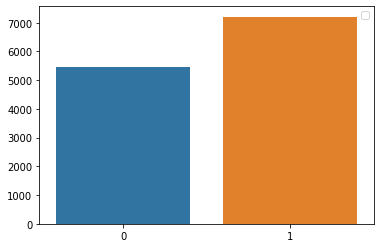

In [52]:
target = 'Y'
sns.barplot(x = (data[target].unique()), y = data[target].value_counts().values)
plt.legend()
print(data[target].value_counts())

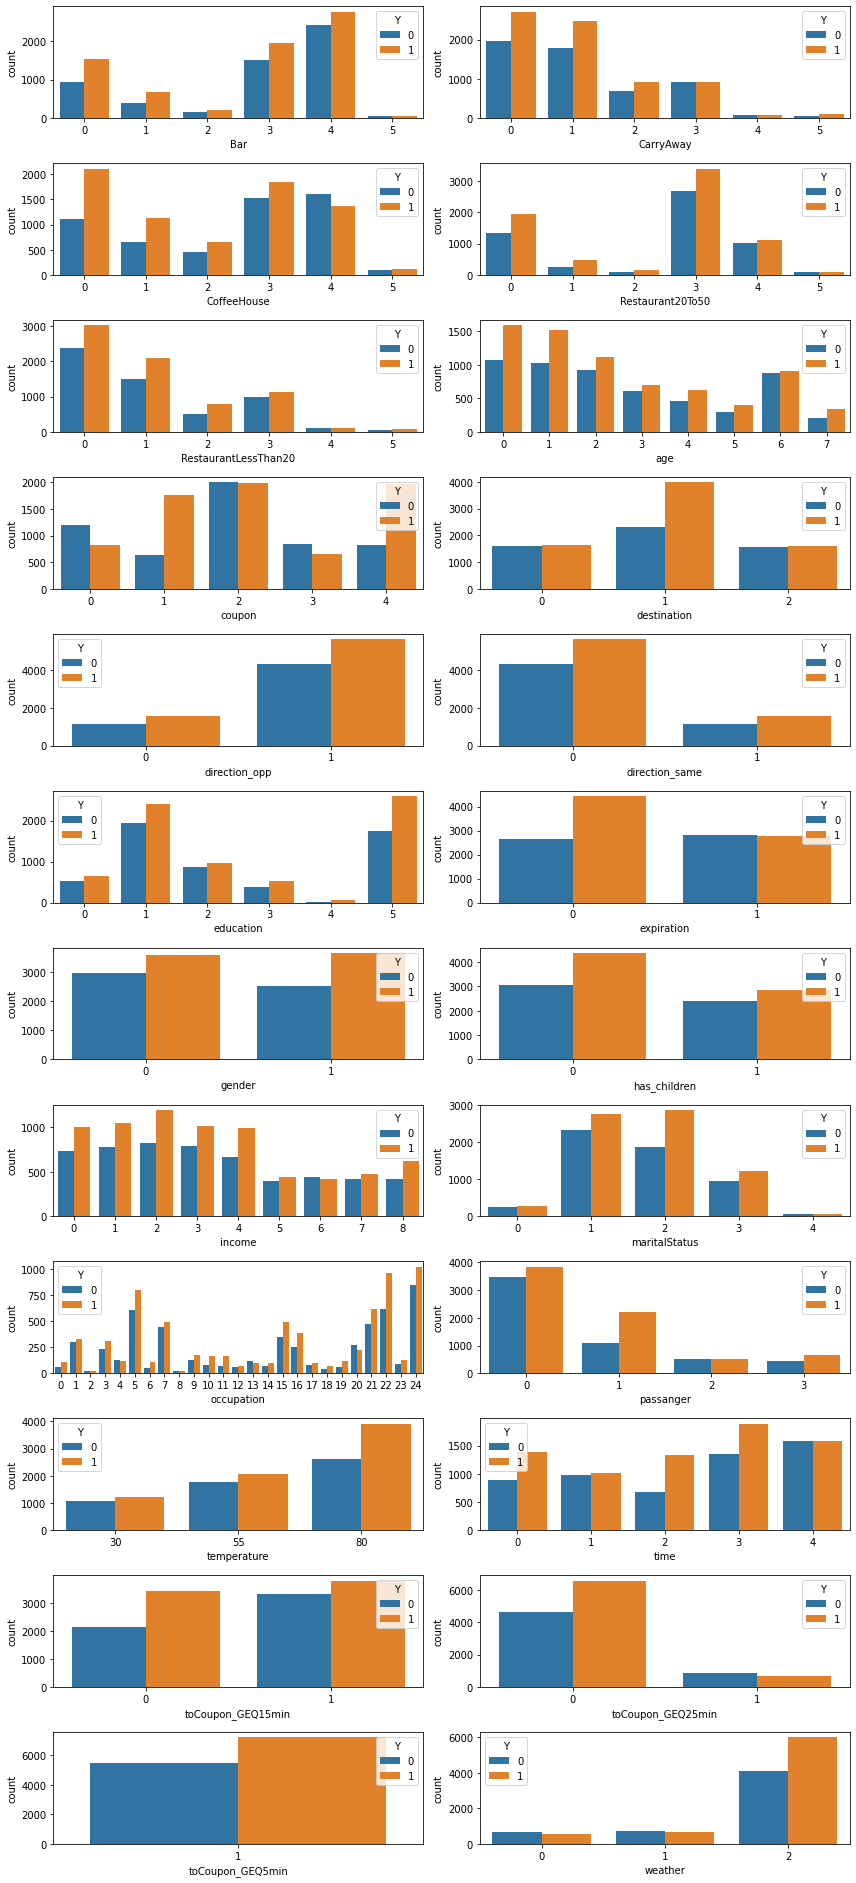

In [53]:
plt.figure(figsize = (12,28))
for a, col in enumerate(data.columns.difference([target])):
    plt.subplot(13, 2, a+1)
    plt.subplots_adjust(wspace = .5, hspace = 1)
    sns.countplot(x = col, data = data, hue = target)
    plt.tight_layout()

# **Data Modelling**

In [54]:
# Separating training and testing sets with stratification
train_set, test_set = train_test_split(data, test_size=0.2, random_state=50)
print('Training set size: %d' % len(train_set))
print('Test set size: %d' % len(test_set))

Training set size: 10147
Test set size: 2537


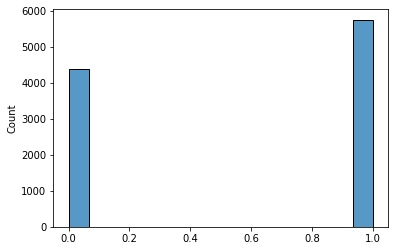

In [55]:
# Checking stratification
y_train = train_set['Y'].values
blob = sns.histplot(y_train, kde=False)

In [56]:
# Copying the training set and separating it into features and label
df = train_set.copy()
y_df = df['Y'].copy()
X_df = df.drop(columns=['Y']).copy()

# **Random Forest Classifier**

In [64]:
# CV scores of a Random Forest Classifier with the Area Under the Receiver Operating Characteristic Curve (auc) metric
clf = RandomForestClassifier() 
scores_cv = cross_val_score(clf, X_df, y_df, cv=10, scoring = make_scorer(auc)) 
# Comparison of the results
print(scores_cv)
print("Random Forest average: %0.8f +/- %0.8f" % (scores_cv.mean(), scores_cv.std()))

[0.75167877 0.72342049 0.73302447 0.72103186 0.74826191 0.74039998
 0.74961639 0.71044996 0.71839326 0.71889269]
Random Forest average: 0.73151698 +/- 0.01430585


In [65]:
# Other possible metrics for CV scoring (because of imbalanced datasets)
scores_balAcc = cross_val_score(clf, X_df, y_df, cv=10, scoring = make_scorer(balAcc))
print(scores_balAcc)
print("\nBalanced Accuracy average: %0.8f +/- %0.8f \n" % (scores_balAcc.mean(), scores_balAcc.std()))
scores_f1 = cross_val_score(clf, X_df, y_df, cv=10, scoring = make_scorer(f1))
print(scores_f1)
print("\nF1 average: %0.8f +/- %0.8f \n" % (scores_f1.mean(), scores_f1.std()))

[0.75287309 0.72065616 0.72401765 0.72786557 0.73399733 0.74555295
 0.74332447 0.70821442 0.72437452 0.70660911]

Balanced Accuracy average: 0.72874853 +/- 0.01457386 

[0.78408129 0.7907743  0.78204082 0.78187919 0.79292929 0.79465776
 0.78875639 0.77073171 0.77629382 0.76793249]

F1 average: 0.78300771 +/- 0.00868291 



### **Random Forest ClassifierGrid Search 10-fold Cross Validation**

In [66]:

# Definition of parameters to test
parameters = {"n_estimators": [50, 150, 3],
                  "criterion": ['gini', 'entropy'],
                  "max_depth": range(2, 6, 3),
                  "min_samples_leaf": range(1, 9, 3),
                  "min_samples_split": range(2, 10, 3),
                  "max_features": ['auto', 'log2']}

# Grid Search for hyper-parameter tuning
clf = GridSearchCV(clf, param_grid=parameters, cv=StratifiedKFold(n_splits=10), scoring=make_scorer(auc))
clf.fit(X_df, y_df)
print(clf)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 6, 3),
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': range(1, 9, 3),
                         'min_samples_split': range(2, 10, 3),
                         'n_estimators': [50, 150, 3]},
             scoring=make_scorer(roc_auc_score))


Average AUC parameter tuning: 0.6455822020738637
coupon
CoffeeHouse
expiration


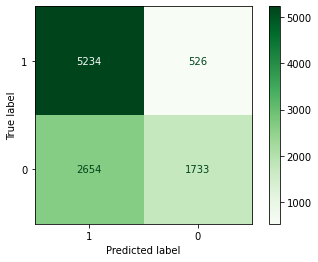

In [67]:
# CV metric of the parameter-tuned Random Forest Classifier
print("Average AUC parameter tuning:", clf.best_score_)
plot_confusion_matrix(estimator=clf, X=X_df, y_true=y_df, labels=[1,0], cmap='Greens')
# Best estimator found with GridSearchCV
clf = clf.best_estimator_
clf

# Top 3 features
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for no in range(3): # top 3
  print(X_df.columns[indices[no]])

In [68]:
# All of the preprocessing was done before splitting into TRAINING and TESTING (because there were no missing values)

# Copying test set
df_test = test_set.copy()

# Separating features and label
y_df_test = df_test['Y'].copy()
X_df_test = df_test.drop(columns=['Y']).copy()

# Making sure the same number of features are used in both the training and testing set
assert X_df.shape[1] == X_df_test.shape[1]
y_pred = clf.predict(X_df_test)

# Metric when generalizing
F1 = f1(y_df_test, y_pred)
F1

0.7633410672853829

# KNN

In [69]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
# KNN
KNN_scores_cv = cross_val_score(neigh, X_df, y_df, cv=10, scoring = make_scorer(auc)) # QUIZ

# Comparison of the results
print(KNN_scores_cv)
print("KNN CV average: %0.8f +/- %0.8f" % (KNN_scores_cv.mean(), KNN_scores_cv.std()))
# Other possible metrics for CV scoring
KNN_scores_balAcc = cross_val_score(neigh,X_df, y_df, cv=10, scoring = make_scorer(balAcc))
print(KNN_scores_balAcc)
print("\n KNN Accuracy average: %0.8f +/- %0.8f \n" % (KNN_scores_balAcc.mean(), KNN_scores_balAcc.std()))
KNN_scores_f1 = cross_val_score(neigh, X_df, y_df, cv=10, scoring = make_scorer(f1))
print(KNN_scores_f1)
print("\n KNN F1 average: %0.8f +/- %0.8f \n" % (KNN_scores_f1.mean(), KNN_scores_f1.std()))


[0.60500111 0.60635559 0.60934139 0.6186191  0.56258898 0.60614599
 0.59452907 0.58049134 0.62196775 0.62274068]
KNN CV average: 0.60277810 +/- 0.01808246
[0.60500111 0.60635559 0.60934139 0.6186191  0.56258898 0.60614599
 0.59452907 0.58049134 0.62196775 0.62274068]

 KNN Accuracy average: 0.60277810 +/- 0.01808246 

[0.66323024 0.66031196 0.66894782 0.68189509 0.64339152 0.67833333
 0.64628821 0.63277826 0.67700258 0.67247387]

 KNN F1 average: 0.66246529 +/- 0.01579521 



## KKN Grid Search

In [70]:
# Definition of parameters to test
k_range = list(range(1, 30))
param_grid = dict(n_neighbors=k_range)

# Grid Search for hyper-parameter tuning
neigh = GridSearchCV(neigh, param_grid,cv=StratifiedKFold(n_splits=10), scoring=make_scorer(auc))
neigh.fit(X_df,y_df)
print(neigh)

# CV metric of the parameter-tuned Random Forest Classifier
print("Average AUC parameter tuning:", neigh.best_score_)

# Best estimator found with GridSearchCV
neigh_classifier = neigh.best_estimator_
neigh_classifier


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]},
             scoring=make_scorer(roc_auc_score))
Average AUC parameter tuning: 0.6113969055432473


KNeighborsClassifier(n_neighbors=12)

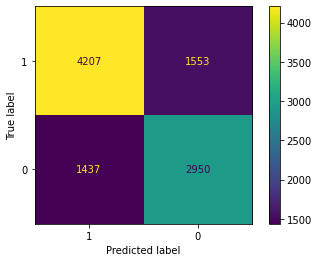

In [71]:
plot_confusion_matrix(estimator=neigh_classifier, X=X_df, y_true=y_df, labels=[1,0])

In [72]:
# All of the preprocessing was done before splitting into TRAINING and TESTING (because there were no missing values)
# Copying test set
df_test = test_set.copy()

# Separating features and label
y_df_test = df_test['Y'].copy()
X_df_test = df_test.drop(columns=['Y']).copy()

# Making sure the same number of features are used in both the training and testing set
assert X_df.shape[1] == X_df_test.shape[1]
neigh_y_pred = neigh.predict(X_df_test)

# Metric when generalizing
F1_KNN= f1(y_df_test, neigh_y_pred)
F1_KNN

0.6645746164574616

# Logistic Regression

In [73]:

LR_classifier = LogisticRegression()
# Logistic Regression 
LR_scores_cv = cross_val_score(LR_classifier, X_df, y_df, cv=10, scoring = make_scorer(auc)) # QUIZ

# Comparison of the results
print("Logistic Regression  average: %0.8f +/- %0.8f" % (LR_scores_cv.mean(), LR_scores_cv.std()))
# Other possible metrics for CV scoring
LR_scores_balAcc = cross_val_score(LR_classifier,X_df, y_df, cv=10, scoring = make_scorer(balAcc))
print(LR_scores_balAcc)
print("\nLogistic Regression Accuracy average: %0.8f +/- %0.8f \n" % (LR_scores_balAcc.mean(), LR_scores_balAcc.std()))
LR_scores_f1 = cross_val_score(LR_classifier, X_df, y_df, cv=10, scoring = make_scorer(f1))
print(LR_scores_f1)
print("\nLogistic Regression F1 average: %0.8f +/- %0.8f \n" % (LR_scores_f1.mean(), LR_scores_f1.std()))


Logistic Regression  average: 0.60876016 +/- 0.00949822
[0.61705502 0.60718608 0.61266531 0.59286613 0.61662396 0.60876202
 0.62465199 0.61203862 0.59856592 0.59718655]

Logistic Regression Accuracy average: 0.60876016 +/- 0.00949822 

[0.70113086 0.700556   0.70625495 0.68992863 0.70700637 0.70790916
 0.7133758  0.70625495 0.69668246 0.68344156]

Logistic Regression F1 average: 0.70125407 +/- 0.00860980 



GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring=make_scorer(roc_auc_score))
Average AUC parameter tuning: 0.6080459345536845


LogisticRegression(C=100.0)

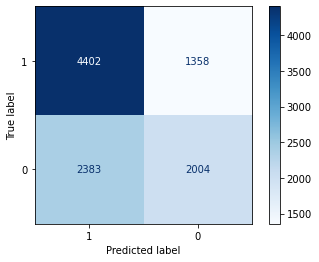

In [74]:
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

LR_classifier = GridSearchCV(LR_classifier, param_grid=parameters, scoring=make_scorer(auc))
LR_classifier.fit(X_df,y_df)
print(LR_classifier)

plot_confusion_matrix(estimator=LR_classifier, X=X_df, y_true=y_df, labels=[1,0], cmap='Blues')

# CV metric of the parameter-tuned Random Forest Classifier
print("Average AUC parameter tuning:", LR_classifier.best_score_)

# Best estimator found with GridSearchCV
LR_classifier = LR_classifier.best_estimator_
LR_classifier

In [75]:
# All of the preprocessing was done before splitting into TRAINING and TESTING (because there were no missing values)

# Copying test set
df_test = test_set.copy()

# Separating features and label
y_df_test = df_test['Y'].copy()
X_df_test = df_test.drop(columns=['Y']).copy()

# Making sure the same number of features are used in both the training and testing set
assert X_df.shape[1] == X_df_test.shape[1]
y_pred_LR = LR_classifier.predict(X_df_test)

# Metric when generalizing
F1_LR = f1(y_df_test, y_pred_LR)
F1_LR

0.6985826771653543

### Before Hyperparameter Tuning

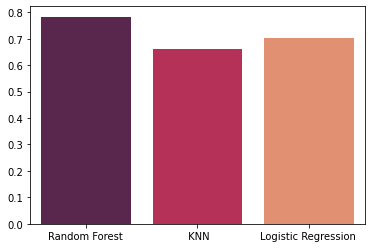

In [76]:
models = ['Random Forest', ' KNN', 'Logistic Regression ']
values = [scores_f1.mean(), KNN_scores_f1.mean(), LR_scores_f1.mean()]
bar = sns.barplot(models, values, palette="rocket")

### After Hyperparameter Tuning

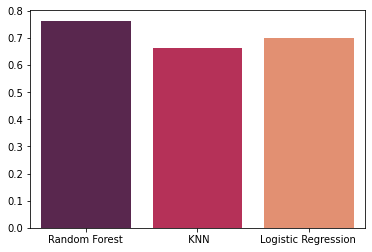

In [77]:
models = ['Random Forest', ' KNN', 'Logistic Regression ']
values = [F1, F1_KNN, F1_LR]
bar = sns.barplot(models, values, palette="rocket")

### **Conclusion**

Proposed models were: Random Forest classifier, k-nearest neighbors classifier, and Logistic regression. After training, crossvaldation , and evaluating all these classifiers, the final comparison plot is created which is concluding that Random Forest classifier is performing well with accuracy 76 percent among three proposed models. 